In [1]:
import matplotlib.pyplot as plt

In [2]:
nlayers = [6, 8, 10, 12]

In [3]:
debru_dect = [99.893, 99.883, 99.907, 99.906]
debru_fp = [0.0050, 0.0051, 0.0052, 0.0042]
debru_pre = [99.933, 99.931, 99.924, 99.943] 
debru_f1 = [99.913, 99.907, 99.918, 99.924]

In [4]:
kadem_dect = [98.592, 98.836, 98.756, 98.755]
kadem_fp = [0.0313, 0.0233, 0.0317, 0.0355]
kadem_pre = [99.565, 99.676, 99.560, 99.535]
kadem_f1 = [99.076, 99.254, 99.156, 99.143]

In [5]:
chord_dect = [98.529, 98.641, 98.689, 98.515]
chord_fp = [0.0381, 0.0400, 0.0262, 0.0343]
chord_pre = [99.484, 99.459, 99.645, 99.536]
chord_f1 = [99.004, 99.048, 99.165, 99.023]

In [6]:
leet_dect = [98.993, 99.006, 98.861, 99.100]
leet_fp = [0.0203, 0.0206, 0.0398, 0.0109]
leet_pre = [99.726, 99.722, 99.463, 99.853]
leet_f1 = [99.358, 99.363, 99.161, 99.475]

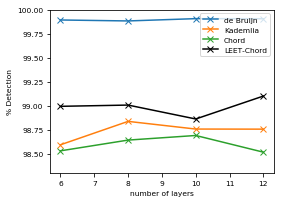

In [36]:
plt.figure(figsize=(4,3))
plt.plot(nlayers, debru_dect, '-x')
plt.plot(nlayers, kadem_dect, '-x')
plt.plot(nlayers, chord_dect, '-x')
plt.plot(nlayers, leet_dect, 'k-x')
plt.xticks(fontsize=7.5, rotation=0)
plt.yticks(fontsize=7.5, rotation=0)
plt.legend(['de Bruijn', 'Kademlia', 'Chord', 'LEET-Chord'], fontsize=7.5, loc='best')
plt.xlabel('number of layers', fontsize=7.5)
plt.ylabel('% Detection', fontsize=7.5)
plt.ylim([98.3, 100])
# plt.savefig('dect_vs_nlay.pdf', bbox_inches='tight', dpi=200)
plt.show()

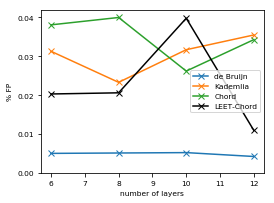

In [34]:
plt.figure(figsize=(4,3))
plt.plot(nlayers, debru_fp, '-x')
plt.plot(nlayers, kadem_fp, '-x')
plt.plot(nlayers, chord_fp, '-x')
plt.plot(nlayers, leet_fp, 'k-x')
plt.xticks(fontsize=7.5, rotation=0)
plt.yticks(fontsize=7.5, rotation=0)
plt.legend(['de Bruijn', 'Kademlia', 'Chord', 'LEET-Chord'], fontsize=7.5, loc='best')
plt.xlabel('number of layers', fontsize=7.5)
plt.ylabel('% FP', fontsize=7.5)
plt.ylim([0.00, 0.042])
# plt.savefig('fp_vs_nlay.pdf', bbox_inches='tight', dpi=200)
plt.show()

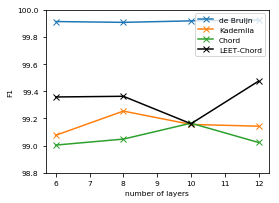

In [35]:
plt.figure(figsize=(4,3))
plt.plot(nlayers, debru_f1, '-x')
plt.plot(nlayers, kadem_f1, '-x')
plt.plot(nlayers, chord_f1, '-x')
plt.plot(nlayers, leet_f1, 'k-x')
plt.xticks(fontsize=7.5, rotation=0)
plt.yticks(fontsize=7.5, rotation=0)
plt.legend(['de Bruijn', 'Kademlia', 'Chord', 'LEET-Chord'], fontsize=7.5, loc='best')
plt.xlabel('number of layers', fontsize=7.5)
plt.ylabel('F1', fontsize=7.5)
plt.ylim([98.8, 100])
# plt.savefig('f1_vs_nlay.pdf', bbox_inches='tight', dpi=200)
plt.show()

#### try metrics for binary classification

In [37]:
from sklearn import metrics

In [38]:
y_pred = [0, 1, 0, 0]
y_true = [0, 1, 0, 1]

In [44]:
metrics.f1_score(y_true, y_pred)

0.6666666666666666

In [42]:
metrics.f1_score(y_true, y_pred, average='macro')

0.7333333333333334

In [43]:
metrics.f1_score(y_true, y_pred, average='micro')

0.75

In [45]:
1 / (1 + 2)

0.3333333333333333

#### try calculating degree profile

In [4]:
import torch
from torch_scatter import scatter_min, scatter_max, scatter_mean, scatter_add

In [5]:
import h5py

In [6]:
!ls data/botnet/ev10k

chord_no100k_ev10k_us_test.hdf5       debru_no100k_ev10k_us_val.hdf5
chord_no100k_ev10k_us_test_old.hdf5   kadem_no100k_ev10k_us_test.hdf5
chord_no100k_ev10k_us_train.hdf5      kadem_no100k_ev10k_us_train.hdf5
chord_no100k_ev10k_us_train_old.hdf5  kadem_no100k_ev10k_us_val.hdf5
chord_no100k_ev10k_us_val.hdf5	      leet_no100k_ev10k_us_test.hdf5
chord_no100k_ev10k_us_val_old.hdf5    leet_no100k_ev10k_us_train.hdf5
debru_no100k_ev10k_us_test.hdf5       leet_no100k_ev10k_us_val.hdf5
debru_no100k_ev10k_us_train.hdf5


In [7]:
f = h5py.File('data/botnet/ev10k/chord_no100k_ev10k_us_train.hdf5', 'r')

In [8]:
x = torch.tensor(f['0/x'][()])
edge_index = torch.tensor(f['0/edge_index'][()])

In [9]:
x

tensor([[  1., 313.],
        [  1.,   3.],
        [  1.,   2.],
        ...,
        [  1.,   2.],
        [  1.,   2.],
        [  1.,   2.]])

In [10]:
edge_index

tensor([[     0,      0,      0,  ..., 143104, 143105, 143106],
        [   282,    430,    799,  ..., 143104, 143105, 143106]])

In [100]:
def ldp(edge_index, x, deg=None):
    """
    Local degree profile: degree, mean(neighbor degrees), max(neighbor degrees), min(neighbor degrees).
    """
    row, col = edge_index
    num_nodes = len(x)
    if deg is None:
        deg = scatter_add(torch.new_ones((edge_index.size(1),), dtype=torch.float), row, dim=0, dim_size=num_nodes)
    deg_j = torch.index_select(deg, 0, col)
    deg_mean = scatter_mean(deg_j, row, dim=0, dim_size=num_nodes)
    deg_max, _ = scatter_max(deg_j, row, dim=0, dim_size=num_nodes)
    deg_min, _ = scatter_min(deg_j, row, dim=0, dim_size=num_nodes)

    return torch.stack([deg, deg_mean, deg_max, deg_min]).t()

In [101]:
degree_profile = ldp(edge_index, x[:, 0], x[:, 1])

In [102]:
degree_profile

tensor([[3.1300e+02, 9.0373e+02, 5.9000e+03, 2.1000e+01],
        [3.0000e+00, 1.8410e+03, 4.2470e+03, 3.0000e+00],
        [2.0000e+00, 9.2500e+01, 1.8300e+02, 2.0000e+00],
        ...,
        [2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00],
        [2.0000e+00, 8.0500e+01, 1.5900e+02, 2.0000e+00],
        [2.0000e+00, 3.2700e+02, 6.5200e+02, 2.0000e+00]])

In [27]:
def next_prob_dist(edge_index, x, deg=None):
    """
    Calculate the probability distribution after another step of random walk.
    """
    row, col = edge_index
    num_nodes = len(x)

    if deg is None:
        deg = scatter_add(torch.new_ones((edge_index.size(1),), dtype=torch.float), row, dim=0, dim_size=num_nodes)
    deg_inv = deg.pow(-1)
    deg_inv[deg_inv == float('inf')] = 0

    x = x * deg_inv.view(x.shape)
    x = torch.index_select(x, 0, row)    # row = edge_index[0]
    x = scatter_add(x, col, dim=0, dim_size=num_nodes)

    return x

In [42]:
x0 = x[:, 0] / len(x)
x1 = next_prob_dist(edge_index, x0, x[:, 1])

In [43]:
x1

tensor([6.4431e-06, 2.3364e-06, 3.5321e-06,  ..., 6.9878e-06, 3.5378e-06,
        3.5046e-06])

In [44]:
x2 = next_prob_dist(edge_index, x1, x[:, 1])

In [45]:
x2    # not less than 1, since we didn't start with <1 probabilities

tensor([2.3861e-04, 3.4041e-06, 2.6992e-06,  ..., 6.9878e-06, 2.1753e-06,
        1.8206e-06])

In [46]:
x3 = next_prob_dist(edge_index, x2, x[:, 1])

In [47]:
x3

tensor([8.2116e-05, 2.1295e-06, 1.6671e-06,  ..., 6.9878e-06, 1.8301e-06,
        1.6434e-06])